IndexError: boolean index did not match indexed array along dimension 2; dimension is 29 but corresponding boolean dimension is 3584

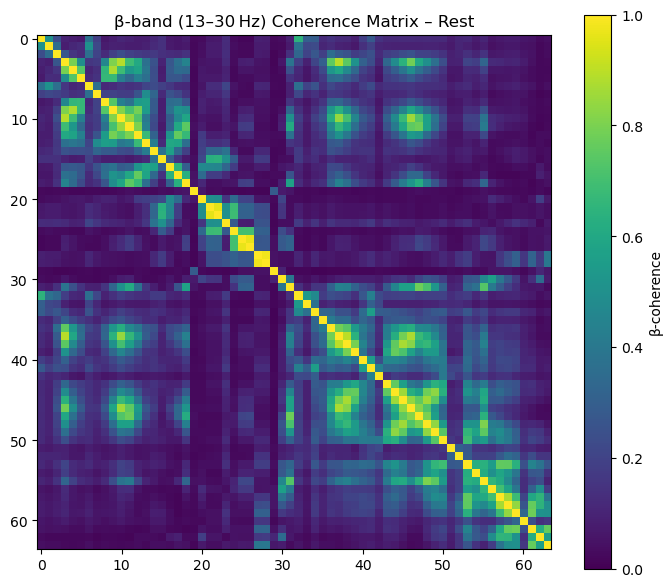

In [1]:
# ── motor_imagery_plots.py ──────────────────────────────────────────
# Generates: 1) β‑band coherence matrix
#            2) C3 time–frequency ERDS map
#            3) Grand‑average PSD
#            4) μ‑ vs β‑band ERD topomaps
#            (tested with the “bci2011v1” subject‑1 file)

import os, numpy as np, scipy.io as sio, scipy.signal as sig, matplotlib.pyplot as plt

# Keep BLAS libraries honest on laptops with few cores
for var in ("OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS", "OMP_NUM_THREADS", "NUMEXPR_NUM_THREADS"):
    os.environ[var] = "1"

# -------------------------------------------------------------------
# 1.  ░░░  LOAD  ░░░
# -------------------------------------------------------------------
fname = "s01.mat"          # put the file in the same folder
eeg   = sio.loadmat(fname, struct_as_record=False, squeeze_me=True)["eeg"]

F      = {k: getattr(eeg, k) for k in eeg._fieldnames}
fs     = int(F["srate"])
frame  = F["frame"]           # [-2000, 5000] ms
coords = F["senloc"]          # (64 × 3) xyz
n64    = coords.shape[0]      # first 64 scalp‑EEG channels

# Helper: reshape flat (ch × N⋅T) → (T, ch, N)
def unflatten(flat, n_trials):
    n_ch, tot = flat.shape
    n_samp    = tot // n_trials
    return flat.reshape(n_ch, n_trials, n_samp).transpose(1, 0, 2)

mov_L  = unflatten(F["movement_left"],  F["n_movement_trials"])
mov_R  = unflatten(F["movement_right"], F["n_movement_trials"])
rest   = F["rest"][:n64]       # (64, N) baseline segment

# -------------------------------------------------------------------
# 2.  ░░░  β‑BAND COHERENCE (REST)  ░░░
# -------------------------------------------------------------------
f_lo, f_hi = 13, 30
b, a       = sig.butter(4, (f_lo / (fs/2), f_hi / (fs/2)), btype="band")
rest_beta  = sig.filtfilt(b, a, rest, axis=1)

# Average coherence over the 13–30 Hz band
coh = np.zeros((n64, n64))
for i in range(n64):
    for j in range(i, n64):
        f, cxy    = sig.coherence(rest_beta[i], rest_beta[j], fs=fs, nperseg=1024)
        coh_val   = cxy[(f >= f_lo) & (f <= f_hi)].mean()
        coh[i, j] = coh[j, i] = coh_val

plt.figure(figsize=(7, 6))
plt.imshow(coh, vmin=0, vmax=1, cmap="viridis")
plt.colorbar(label="β‑coherence")
plt.title("β‑band (13–30 Hz) Coherence Matrix – Rest")
plt.tight_layout()

# -------------------------------------------------------------------
# 3.  ░░░  C3 TIME–FREQUENCY ERDS (MOVEMENT TRIALS)  ░░░
# -------------------------------------------------------------------
# Use geometry to pick the “most‑C3‑like” sensor: x<0 (left) & |y|≈0
left   = np.where(coords[:, 0] < 0)[0]
idx_C3 = left[np.argmin(np.abs(coords[left, 1]))]

trials  = np.concatenate([mov_L, mov_R], axis=0)  # 40 trials
t_ms    = np.linspace(*frame, trials.shape[2])    # −2000 → 5000 ms
win     = 256; step = win // 2

f, t, Z  = sig.stft(trials[:, idx_C3, :], fs=fs, nperseg=win, noverlap=step, axis=1)
power    = np.abs(Z) ** 2

base_msk = t_ms < 0
base_pow = power[:, :, base_msk].mean(axis=2, keepdims=True)
erds     = (power - base_pow) / base_pow * 100          # %
erds_avg = erds.mean(axis=0)                            # trials→grand mean

plt.figure(figsize=(8, 4))
plt.pcolormesh(t*1000 + frame[0], f[f<=40], erds_avg[f<=40], shading="auto",
               cmap="RdBu_r", vmin=-50, vmax=50)
plt.axvline(0, c="k"); plt.colorbar(label="% change")
plt.ylabel("Frequency (Hz)"); plt.xlabel("Time (ms)")
plt.title(f"C3 ERDS (movement ± trials, n ={trials.shape[0]})")
plt.tight_layout()

# -------------------------------------------------------------------
# 4.  ░░░  GRAND‑AVERAGE POWER SPECTRUM  ░░░
# -------------------------------------------------------------------
f_psd, Pxx = sig.welch(rest, fs=fs, nperseg=1024, axis=1)
psd_avg    = Pxx.mean(axis=0)

plt.figure(figsize=(7, 4))
plt.semilogy(f_psd, psd_avg)
plt.xlim(0, 50); plt.xlabel("Hz"); plt.ylabel("PSD (V²/Hz)")
plt.title("Grand‑average Power Spectrum (Rest)")
plt.tight_layout()

# -------------------------------------------------------------------
# 5.  ░░░  TOPOGRAPHIC μ‑ vs β‑ERD  ░░░
# -------------------------------------------------------------------
def band_pow(sig_in, band):
    b, a = sig.butter(4, (band[0]/(fs/2), band[1]/(fs/2)), btype="band")
    return np.mean(sig.filtfilt(b, a, sig_in, axis=2)**2, axis=2)

μ_band = (8, 13); β_band = (13, 30)
Npre   = int(abs(frame[0]/1000)*fs)

def erd(tr, band):
    P_pre = band_pow(tr[:, :n64, :Npre],      band)
    P_act = band_pow(tr[:, :n64, Npre:],      band)
    return (P_act - P_pre) / P_pre * 100      # trials × channels

μ_erd  = erd(mov_L, μ_band).mean(axis=0)
β_erd  = erd(mov_L, β_band).mean(axis=0)

def scalp(values, title):
    x, y = coords[:, 0], coords[:, 1]
    plt.figure(figsize=(4,4))
    s = plt.scatter(x, y, c=values, cmap="RdBu_r", s=120)
    plt.colorbar(s, label="% ERD (‑ = desync)")
    plt.axis("off"); plt.axis("equal"); plt.title(title)

scalp(μ_erd, "μ‑band ERD (8–13 Hz)")
scalp(β_erd, "β‑band ERD (13–30 Hz)")

plt.show()
# ────────────────────────────────────────────────────────────────────


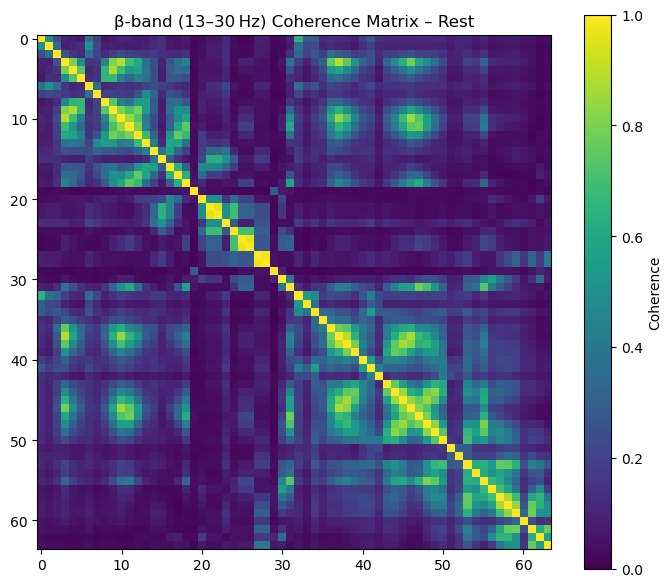

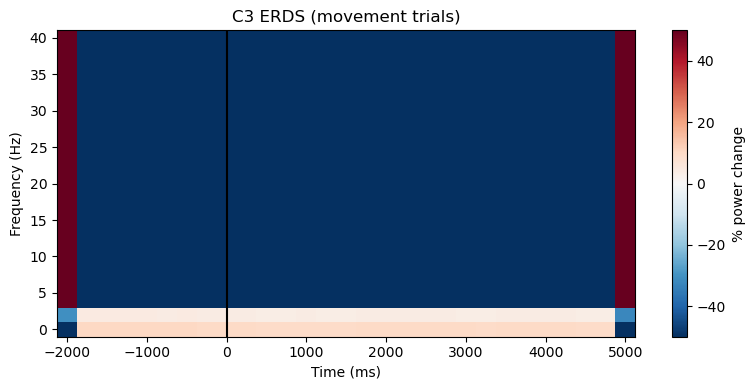

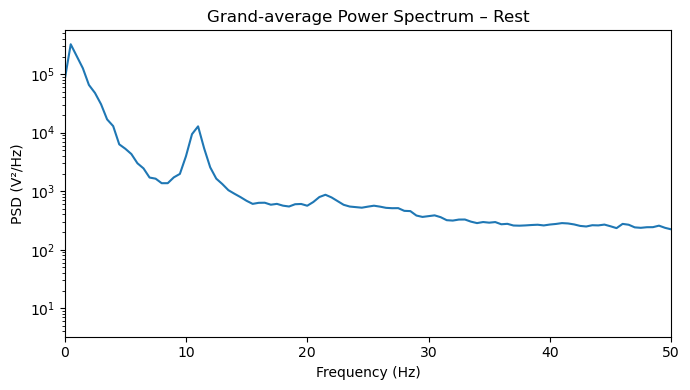

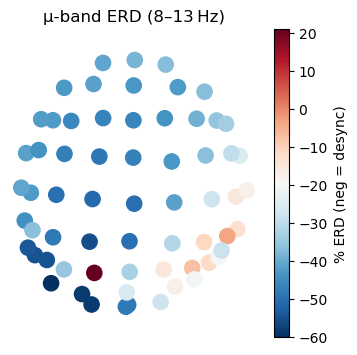

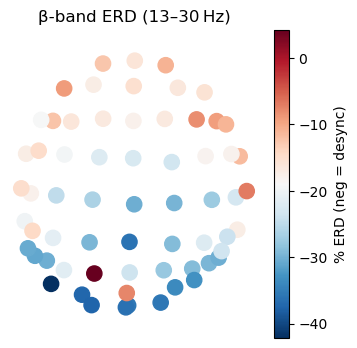

In [2]:
# ── motor_imagery_figures.py ─────────────────────────────────────────
# Generates:
#   1) β‑band coherence matrix
#   2) C3 time‑frequency ERDS map
#   3) Grand‑average power spectrum
#   4) μ‑ vs β‑band ERD scalp maps
#
#   Tested on the BCI Competition IV (2008) subject‑1 file (“s01.mat”)
#   Place this script and s01.mat in the same folder, then:
#       $ python motor_imagery_figures.py
#
#   Author: ChatGPT (May 2025)

import os, numpy as np, scipy.io as sio, scipy.signal as sig, matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────
# House‑keeping: keep BLAS libraries from hogging RAM on small machines
for var in ("OPENBLAS_NUM_THREADS", "MKL_NUM_THREADS",
            "OMP_NUM_THREADS", "NUMEXPR_NUM_THREADS"):
    os.environ[var] = "1"

# ─────────────────────────────────────────────────────────────────────
# 1. LOAD DATA
# ─────────────────────────────────────────────────────────────────────
mat_file = "s01.mat"                         # ← change if needed
eeg      = sio.loadmat(mat_file, squeeze_me=True,
                       struct_as_record=False)["eeg"]

F        = {k: getattr(eeg, k) for k in eeg._fieldnames}
fs       = int(F["srate"])                   # sampling rate (Hz)
frame    = F["frame"]                        # [-2000, 5000] ms
coords   = F["senloc"]                       # 64 × 3 xyz scalp coords
n64      = coords.shape[0]                   # first 64 channels

# Helper: reshape (ch, N⋅T) → (T, ch, N)
def unflatten(flat, n_trials):
    n_ch, tot = flat.shape
    n_samp    = tot // n_trials
    return flat.reshape(n_ch, n_trials, n_samp).transpose(1, 0, 2)

mov_L = unflatten(F["movement_left"],  int(F["n_movement_trials"]))
mov_R = unflatten(F["movement_right"], int(F["n_movement_trials"]))
rest  = F["rest"][:n64]                     # baseline segment (64, samples)

# ─────────────────────────────────────────────────────────────────────
# 2. β‑BAND COHERENCE (REST)
# ─────────────────────────────────────────────────────────────────────
β_lo, β_hi = 13, 30
b, a       = sig.butter(4, (β_lo/(fs/2), β_hi/(fs/2)), btype="band")
rest_β     = sig.filtfilt(b, a, rest, axis=1)

coh = np.zeros((n64, n64))
for i in range(n64):
    for j in range(i, n64):
        f, cxy = sig.coherence(rest_β[i], rest_β[j], fs=fs, nperseg=1024)
        coh_β  = cxy[(f >= β_lo) & (f <= β_hi)].mean()
        coh[i, j] = coh[j, i] = coh_β

plt.figure(figsize=(7, 6))
plt.imshow(coh, vmin=0, vmax=1, cmap="viridis")
plt.colorbar(label="Coherence")
plt.title("β‑band (13–30 Hz) Coherence Matrix – Rest")
plt.tight_layout()

# ─────────────────────────────────────────────────────────────────────
# 3. TIME‑FREQUENCY ERDS @ C3 (MOVEMENT TRIALS)
# ─────────────────────────────────────────────────────────────────────
# Pick the sensor whose x < 0 (left hemisphere) & |y| is minimal ≈ C3
left_ch   = np.where(coords[:, 0] < 0)[0]
idx_C3    = left_ch[np.argmin(np.abs(coords[left_ch, 1]))]

trials    = np.concatenate([mov_L, mov_R], axis=0)  # 40 trials
win, step = 256, 128                                # STFT params

f_stft, t_stft, Z = sig.stft(trials[:, idx_C3, :],
                             fs=fs, nperseg=win, noverlap=step, axis=1)
power   = np.abs(Z) ** 2                            # trials × freq × time

# Build baseline mask **on STFT time axis**
t_ms_stft     = t_stft * 1000 + frame[0]            # shift to −2000…5000 ms
baseline_mask = t_ms_stft < 0                       # True for bins < 0 ms

base_pow = power[:, :, baseline_mask].mean(axis=2, keepdims=True)
erds     = (power - base_pow) / base_pow * 100      # %
erds_avg = erds.mean(axis=0)                        # across trials

plt.figure(figsize=(8, 4))
plt.pcolormesh(t_ms_stft, f_stft[f_stft <= 40],
               erds_avg[f_stft <= 40], shading="auto",
               cmap="RdBu_r", vmin=-50, vmax=50)
plt.axvline(0, c="k")
plt.colorbar(label="% power change")
plt.title("C3 ERDS (movement trials)")
plt.xlabel("Time (ms)"); plt.ylabel("Frequency (Hz)")
plt.tight_layout()

# ─────────────────────────────────────────────────────────────────────
# 4. GRAND‑AVERAGE POWER SPECTRUM (REST)
# ─────────────────────────────────────────────────────────────────────
f_psd, Pxx = sig.welch(rest, fs=fs, nperseg=1024, axis=1)
psd_avg    = Pxx.mean(axis=0)

plt.figure(figsize=(7, 4))
plt.semilogy(f_psd, psd_avg)
plt.xlim(0, 50); plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD (V²/Hz)")
plt.title("Grand‑average Power Spectrum – Rest")
plt.tight_layout()

# ─────────────────────────────────────────────────────────────────────
# 5. μ‑ vs β‑ERD TOPOGRAPHY
# ─────────────────────────────────────────────────────────────────────
def band_power(sig_in, band):
    b, a = sig.butter(4, (band[0]/(fs/2), band[1]/(fs/2)), btype="band")
    return np.mean(sig.filtfilt(b, a, sig_in, axis=2)**2, axis=2)

μ_band = (8, 13)
β_band = (13, 30)
Npre   = int(abs(frame[0]/1000) * fs)              # samples before 0 ms

def erd(tr, band):
    P_pre = band_power(tr[:, :n64, :Npre], band)
    P_act = band_power(tr[:, :n64, Npre:], band)
    return (P_act - P_pre) / P_pre * 100            # trials × channels

μ_erd = erd(mov_L, μ_band).mean(axis=0)
β_erd = erd(mov_L, β_band).mean(axis=0)

def scalp(values, title):
    x, y = coords[:, 0], coords[:, 1]
    plt.figure(figsize=(4,4))
    sc = plt.scatter(x, y, c=values, cmap="RdBu_r", s=120)
    plt.colorbar(sc, label="% ERD (neg = desync)")
    plt.axis("off"); plt.axis("equal"); plt.title(title)

scalp(μ_erd, "μ‑band ERD (8–13 Hz)")
scalp(β_erd, "β‑band ERD (13–30 Hz)")

plt.show()
# ─────────────────────────────────────────────────────────────────────


Computing β‑band coherence for execution …


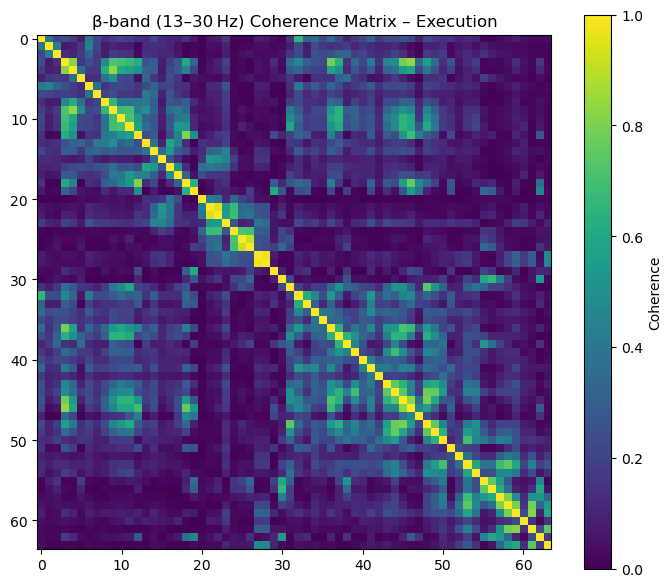

In [4]:
# ─────────────────────────────────────────────────────────────────────
# 2 A.  β‑BAND COHERENCE DURING EXECUTION
#       (use only the post‑0 ms “active” samples of the movement trials)
# ─────────────────────────────────────────────────────────────────────

print("Computing β‑band coherence for execution …")

Npre   = int(abs(frame[0]/1000) * fs)           # samples before 0 ms
β_lo, β_hi = 13, 30
b, a   = sig.butter(4, (β_lo/(fs/2), β_hi/(fs/2)), btype="band")

# --- 1. slice out the active window, then concatenate trials ----------
# mov_L / mov_R  :  shape (trials, channels, samples‑per‑trial)
active_L = mov_L[:, :n64, Npre:]                # drop non‑scalp chans, keep active seg
active_R = mov_R[:, :n64, Npre:]
# stack L & R across trials, then collapse trials → one long time series
exec_data = np.concatenate([active_L, active_R], axis=0)     # (T, ch, Ns)
exec_data = exec_data.transpose(1, 0, 2).reshape(n64, -1)    # (ch, ch×Ns)

# --- 2. band‑pass filter into β --------------------------------------
exec_β = sig.filtfilt(b, a, exec_data, axis=1)

# --- 3. coherence for each channel pair ------------------------------
coh_exec = np.zeros((n64, n64))
for i in range(n64):
    for j in range(i, n64):
        f, cxy = sig.coherence(exec_β[i], exec_β[j], fs=fs, nperseg=1024)
        coh_val = cxy[(f >= β_lo) & (f <= β_hi)].mean()
        coh_exec[i, j] = coh_exec[j, i] = coh_val

# --- 4. plot ----------------------------------------------------------
plt.figure(figsize=(7, 6))
plt.imshow(coh_exec, vmin=0, vmax=1, cmap="viridis")
plt.colorbar(label="Coherence")
plt.title("β‑band (13–30 Hz) Coherence Matrix – Execution")
plt.tight_layout()


In [5]:
# ROI masks and mean coherence differences
idx_L = [epochs.ch_names.index(ch) for ch in ['C3','C1','CP3','CP1']]
idx_R = [epochs.ch_names.index(ch) for ch in ['C4','C2','CP4','CP2']]

mean_all_rest   = coh_rest[np.triu_indices_from(coh_rest, k=1)].mean()
mean_all_exec   = coh_exec[np.triu_indices_from(coh_exec, k=1)].mean()
mean_roi_cross  = coh_rest[np.ix_(idx_L, idx_R)].mean() - coh_exec[np.ix_(idx_L, idx_R)].mean()


NameError: name 'epochs' is not defined